Классификатор для распознавания жанра музыки

Примените подход к музыке как к тексту и напишите сверточный классификатор для подготовленных данных. Для этого:

 1. Измените подготовку данных так, чтобы набор признаков, извлекаемый из аудиофайла, был представлен в виде последовательностей векторов признаков. Последовательности должны быть фиксированного размера и выбираться скользящим окном c заданным шагом;
 2. Длину последовательности, размер шага и достаточный набор признаков определите самостоятельно исходя из требований к точности классификатора;
 3. Разработайте классификатор на одномерных сверточных слоях **Conv1D** с точностью классификации жанра на тестовых данных не ниже **60%**, а на обучающих файлах - **68%** и выше;
 4. Используйте за основу фреймворк с урока, но при желании разработайте свои инструменты.
 

Импортируем необходимые библиотеки:

In [ ]:
# Массивы
import numpy as np

# Отрисовка графиков
import matplotlib.pyplot as plt

# Загрузка из google облака
import gdown

# Преобразование категориальных данных в one hot encoding
from tensorflow.keras.utils import to_categorical

# Работа с папками и файлами
import os

# Утилиты работы со временем
import time

# Работа со случайными числами
import random

# Математические функции
import math

# Сохранение и загрузка структур данных Python
import pickle

# Параметризация аудио
import librosa

# Оптимизаторы для обучения моделей
from tensorflow.keras.optimizers import Adam, RMSprop

# Конструирование и загрузка моделей нейронных сетей
from tensorflow.keras.models import Sequential, Model, load_model

# Основные слои
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM
from tensorflow.keras.layers import MaxPooling1D, AveragePooling1D, SpatialDropout1D

# Разбиение на обучающую и проверочную выборку
from sklearn.model_selection import train_test_split

# Кодирование категориальных меток, нормирование числовых данных
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Матрица ошибок классификатора
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Отключение предупреждений
import warnings
warnings.filterwarnings('ignore')

from tensorflow.keras import utils

%matplotlib inline 

Загрузим датасет в Colab:

In [ ]:
# Загрузка датасета из облака
gdown.download('https://storage.googleapis.com/datasets_ai/Base/12_audio/genres.zip', None, quiet=True)

'genres.zip'

In [ ]:
# Распаковка архива на локальный диск colab
!unzip -qo genres.zip

# Проверка выгруженных папок
!ls genres 

# Проверка содержимого одной папки
!ls genres/blues

д
y
a
blues  classical  country  disco  hiphop  jazz	metal  pop  reggae  rock
blues.00000.au	blues.00020.au	blues.00040.au	blues.00060.au	blues.00080.au
blues.00001.au	blues.00021.au	blues.00041.au	blues.00061.au	blues.00081.au
blues.00002.au	blues.00022.au	blues.00042.au	blues.00062.au	blues.00082.au
blues.00003.au	blues.00023.au	blues.00043.au	blues.00063.au	blues.00083.au
blues.00004.au	blues.00024.au	blues.00044.au	blues.00064.au	blues.00084.au
blues.00005.au	blues.00025.au	blues.00045.au	blues.00065.au	blues.00085.au
blues.00006.au	blues.00026.au	blues.00046.au	blues.00066.au	blues.00086.au
blues.00007.au	blues.00027.au	blues.00047.au	blues.00067.au	blues.00087.au
blues.00008.au	blues.00028.au	blues.00048.au	blues.00068.au	blues.00088.au
blues.00009.au	blues.00029.au	blues.00049.au	blues.00069.au	blues.00089.au
blues.00010.au	blues.00030.au	blues.00050.au	blues.00070.au	blues.00090.au
blues.00011.au	blues.00031.au	blues.00051.au	blues.00071.au	blues.00091.au
blues.00012.au	blues.0

In [ ]:
# Ваше решение

In [ ]:
# Установка констант

FILE_DIR = './genres'                     # Папка с файлами датасета
CLASS_LIST = os.listdir(FILE_DIR)         # Список классов, порядок меток не определен!
CLASS_LIST.sort()                         # Сортировка списка классов для фиксации порядка меток
CLASS_COUNT = len(CLASS_LIST)             # Количество классов
CLASS_FILES = 100                         # Общее количество файлов в каждом классе
FILE_INDEX_TRAIN_SPLIT = 90               # Количество файлов каждого класса на основной набор
VALIDATION_SPLIT = 0.1                    # Доля проверочной выборки в основном наборе
DURATION_SEC = 30                         # Анализируемая длительность аудиосигнала
N_FFT = 8192                              # Размер окна преобразования Фурье для расчета спектра
HOP_LENGTH = 512                          # Объем данных для расчета одного набора признаков

In [ ]:
# Проверка списка классов
print(CLASS_LIST)

['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']


In [ ]:
# Функция параметризации аудио

def get_features(y,                     # волновое представление сигнала
                 sr,                    # частота дискретизации сигнала y
                 n_fft=N_FFT,           # размер скользящего окна БПФ
                 hop_length=HOP_LENGTH  # шаг скользящего окна БПФ
                 ):
    # Вычисление различных параметров (признаков) аудио

    # Хромаграмма
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    # Мел-кепстральные коэффициенты
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    # Среднеквадратическая амплитуда
    rmse = librosa.feature.rms(y=y, hop_length=hop_length)
    # Спектральный центроид
    spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    # Ширина полосы частот
    spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    # Спектральный спад частоты
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    # Пересечения нуля
    zcr = librosa.feature.zero_crossing_rate(y, hop_length=hop_length)
    
    # Сборка признаков в общий список:
    # На один файл несколько векторов признаков, количество определяется
    # продолжительностью аудио и параметром hop_length в функциях расчета признаков
    features = {'rmse': rmse, 
                'spct': spec_cent, 
                'spbw': spec_bw,
                'roff': rolloff,
                'zcr' : zcr,
                'mfcc': mfcc,
                'stft': chroma_stft}

    return features

In [ ]:
# Функция объединения признаков в набор векторов

def stack_features(feat  # словарь признаков, отдельные векторы по ключу каждого признака
                   ):
    features = None
    for v in feat.values():
        features = np.vstack((features, v)) if features is not None else v

    return features.T

In [ ]:
# Функция формирования набора признаков и метки класса для аудиофайла

def get_feature_list_from_file(class_index,  # индекс класса файла song_name
                               song_name,    # имя аудиофайла
                               duration_sec  # длительность аудио в секундах
                               ):
    # Загрузка в y первых duration_sec секунд аудиосигнала
    y, sr = librosa.load(song_name, mono=True, duration=duration_sec)

    # Извлечение параметров из аудиосигнала
    features = get_features(y, sr)
    feature_set = stack_features(features)

    # Перевод номера класса в one hot encoding
    y_label = to_categorical(class_index, CLASS_COUNT)

    return feature_set, y_label

In [ ]:
# Функция формирования подвыборки признаков и меток класса для одного файла

def process_file(class_index,  # индекс класса аудиофайла
                 file_index,   # индекс (порядковый номер) аудиофайла в папке класса
                 duration_sec  # длительность аудио в секундах
                 ):
    x_list = []
    y_list = []
    class_name = CLASS_LIST[class_index]

    # Извлечение имени произведения
    song_name = f'{FILE_DIR}/{class_name}/{class_name}.{str(file_index).zfill(5)}.au'

    # Выборка признаков и метки класса для произведения
    feature_set, y_label = get_feature_list_from_file(class_index, 
                                                        song_name,
                                                        duration_sec)

    # Добавление данных в наборы
    for j in range(feature_set.shape[0]):
        x_list.append(feature_set[j])
        y_list.append(y_label)

    # Возврат имени файла и numpy-массивов призанков и меток класса
    return song_name, \
           np.array(x_list).astype('float32'), \
           np.array(y_list).astype('float32')

In [ ]:
# Функция формирования набора данных из файлов всех классов по диапазону номеров файлов

def extract_data(file_index_start,          # начальный индекс аудиофайла
                 file_index_end,            # конечный индекс аудиофайла (не достигая)
                 duration_sec=DURATION_SEC  # длительность аудио в секундах
                 ):

    # Списки для последовательностей входных данных и меток класса
    x_data = []
    y_data = []

    # Фиксация времени старта формирования выборки
    curr_time = time.time()

    # Для всех классов:
    for class_index in range(len(CLASS_LIST)):
        x_data_cl=None
        # Для всех файлов текущего класса из заданного диапазона номеров:
        for file_index in range(file_index_start, file_index_end):
            # Обработка одного файла и добавление данных к общим массивам
            _, file_x_data, file_y_data = process_file(class_index, file_index, duration_sec)
            x_data_cl = file_x_data if x_data_cl is None else np.vstack([x_data_cl, file_x_data])
        x_data.append(x_data_cl)

        y_data.append(class_index)# = file_y_data if y_data is None else np.vstack([y_data, file_y_data])

        # Вывод информации о готовности обработки датасета
        print(f'Жанр {CLASS_LIST[class_index]} готов -> {round(time.time() - curr_time)} c')
        curr_time = time.time()

    # Возврат массивов набора данных
    return x_data, y_data

In [ ]:
# Формирование тренировочного (основного) набора данных
x_train_data, y_train_data = extract_data(0, FILE_INDEX_TRAIN_SPLIT)

Жанр blues готов -> 141 c
Жанр classical готов -> 145 c
Жанр country готов -> 141 c
Жанр disco готов -> 139 c
Жанр hiphop готов -> 137 c
Жанр jazz готов -> 139 c
Жанр metal готов -> 142 c
Жанр pop готов -> 144 c
Жанр reggae готов -> 145 c
Жанр rock готов -> 144 c


In [ ]:
# Формирование тренировочного (основного) набора данных
x_test_data, y_test_data = extract_data(FILE_INDEX_TRAIN_SPLIT,100)

Жанр blues готов -> 16 c
Жанр classical готов -> 16 c
Жанр country готов -> 16 c
Жанр disco готов -> 16 c
Жанр hiphop готов -> 16 c
Жанр jazz готов -> 16 c
Жанр metal готов -> 16 c
Жанр pop готов -> 16 c
Жанр reggae готов -> 16 c
Жанр rock готов -> 16 c


In [ ]:
for i,seq in enumerate(x_train_data):
  print(i,len(seq))

0 116280
1 116280
2 116280
3 116280
4 116278
5 116280
6 116280
7 116280
8 116280
9 116280


In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
# Сохранение/восстановление датасета аудио
# Данные привязаны к порядку следования меток классов!
# Порядок классов фиксирован сортировкой списка меток классов
with open('/content/drive/My Drive/NN/audio_data_train.pickle', 'wb') as f:
    pickle.dump((x_train_data, y_train_data), f)
with open('/content/drive/My Drive/NN/audio_data_test.pickle', 'wb') as f:
    pickle.dump((x_test_data, y_test_data), f)


In [ ]:
with open('/content/drive/My Drive/NN/audio_data_train.pickle', 'rb') as f:
    x_train_data, y_train_data = pickle.load(f)
with open('/content/drive/My Drive/NN/audio_data_test.pickle', 'rb') as f:
    x_test_data, y_test_data = pickle.load(f)

In [ ]:
def split_sequence(sequence,   # Последовательность индексов
                   win_size,   # Размер окна для деления на примеры
                   hop):       # Шаг окна

    # Последовательность разбивается на части до последнего полного окна
    return [sequence[i:i + win_size] for i in range(0, len(sequence) - win_size + 1, hop)]

In [ ]:
def vectorize_sequence(seq_list,    # Список последовательностей индексов 
                       win_size,    # Размер окна для деления на примеры
                       hop):        # Шаг окна

    # В списке последовательности следуют в порядке их классов (их кол-во сповпадает с кол-вом классов)
    class_count = len(seq_list)

    # Списки для исходных векторов и категориальных меток класса
    x, y = [], []

    # Для каждого класса:
    for cls in range(class_count):

        # Разбиение последовательности класса cls на отрезки
        vectors = split_sequence(seq_list[cls], win_size, hop)

        # Добавление отрезков в выборку

        x += vectors
        
        # Для всех отрезков класса cls добавление меток класса в виде OHE
        y += [utils.to_categorical(cls, class_count)] * len(vectors)

    # Возврат результатов как numpy-массивов
    return np.array(x), np.array(y)

In [ ]:
WIN_SIZE=200
WIN_HOP=20
# Формирование обучающей выборки
x_train, y_train = vectorize_sequence(x_train_data, WIN_SIZE, WIN_HOP) 
# Формирование тестовой выборки
x_test, y_test = vectorize_sequence(x_test_data, WIN_SIZE, WIN_HOP)

In [ ]:
model = Sequential()                                            # Создание последовательной модели нейросети
model.add(Conv1D(32, 11, activation='relu', input_shape = x_train[0].shape))#input_dim=x_train[0].shape))
model.add(Dropout(0.2))
model.add(Conv1D(32, 7, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D())
model.add(Conv1D(64, 7, activation='relu', input_shape = x_train[0].shape))#input_dim=x_train[0].shape))
model.add(Dropout(0.2))
model.add(Conv1D(64, 7, activation='relu'))
model.add(MaxPooling1D())

model.add(BatchNormalization())
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(50, activation="relu"))                         # Второй полносвязный слой
model.add(Dropout(0.5))
model.add(Dense(33, activation="relu"))                         # Третий полносвязный слой
model.add(BatchNormalization())                                 # Слой пакетной нормализации
model.add(Dense(y_train.shape[-1], activation='softmax'))             # Выходной полносвязный слой
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()
history = model.fit(x_train,y_train,epochs=20,batch_size=32,validation_data=(x_test, y_test))   # Проверочная выборка и метки классов проверочной выборки 



Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_111 (Conv1D)         (None, 190, 32)           13056     
                                                                 
 dropout_88 (Dropout)        (None, 190, 32)           0         
                                                                 
 conv1d_112 (Conv1D)         (None, 184, 32)           7200      
                                                                 
 batch_normalization_84 (Bat  (None, 184, 32)          128       
 chNormalization)                                                
                                                                 
 max_pooling1d_89 (MaxPoolin  (None, 92, 32)           0         
 g1D)                                                            
                                                                 
 conv1d_113 (Conv1D)         (None, 86, 64)          

Точность жанра 66%

In [ ]:
model = Sequential()                                            # Создание последовательной модели нейросети
model.add(BatchNormalization(input_shape = x_train[0].shape))
model.add(Conv1D(16, 11, activation='relu'))#input_dim=x_train[0].shape))
model.add(MaxPooling1D())
model.add(Conv1D(32, 5, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D())
model.add(Conv1D(64, 5, activation='relu', input_shape = x_train[0].shape))#input_dim=x_train[0].shape))
model.add(MaxPooling1D())
model.add(Conv1D(128, 5, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D())

model.add(BatchNormalization())
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(50, activation="relu"))                         # Второй полносвязный слой
model.add(Dropout(0.5))
model.add(Dense(33, activation="relu"))                         # Третий полносвязный слой
model.add(BatchNormalization())                                 # Слой пакетной нормализации
model.add(Dense(y_train.shape[-1], activation='softmax'))             # Выходной полносвязный слой
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()
history = model.fit(x_train,y_train,epochs=20,batch_size=32,validation_data=(x_test, y_test))   # Проверочная выборка и метки классов проверочной выборки 


Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_64 (Bat  (None, 200, 37)          148       
 chNormalization)                                                
                                                                 
 conv1d_83 (Conv1D)          (None, 190, 16)           6528      
                                                                 
 max_pooling1d_64 (MaxPoolin  (None, 95, 16)           0         
 g1D)                                                            
                                                                 
 conv1d_84 (Conv1D)          (None, 91, 32)            2592      
                                                                 
 batch_normalization_65 (Bat  (None, 91, 32)           128       
 chNormalization)                                                
                                                     

In [ ]:
model = Sequential()                                            # Создание последовательной модели нейросети
model.add(BatchNormalization(input_shape = x_train[0].shape))
model.add(Conv1D(16, 11, activation='relu'))#input_dim=x_train[0].shape))
model.add(MaxPooling1D())
model.add(Conv1D(32, 5, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D())
model.add(Conv1D(64, 5, activation='relu', input_shape = x_train[0].shape))
model.add(MaxPooling1D())
model.add(Conv1D(128, 5, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D())
model.add(Conv1D(256, 3, activation='relu', input_shape = x_train[0].shape))
model.add(MaxPooling1D())
model.add(Conv1D(512, 3, activation='relu'))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(50, activation="relu"))                         # Второй полносвязный слой
model.add(Dropout(0.5))
model.add(Dense(33, activation="relu"))                         # Третий полносвязный слой
model.add(BatchNormalization())                                 # Слой пакетной нормализации
model.add(Dense(y_train.shape[-1], activation='softmax'))             # Выходной полносвязный слой
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()
history = model.fit(x_train,y_train,epochs=20,batch_size=32,validation_data=(x_test, y_test))   # Проверочная выборка и метки классов проверочной выборки 

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_79 (Bat  (None, 200, 37)          148       
 chNormalization)                                                
                                                                 
 conv1d_105 (Conv1D)         (None, 190, 16)           6528      
                                                                 
 max_pooling1d_84 (MaxPoolin  (None, 95, 16)           0         
 g1D)                                                            
                                                                 
 conv1d_106 (Conv1D)         (None, 91, 32)            2592      
                                                                 
 batch_normalization_80 (Bat  (None, 91, 32)           128       
 chNormalization)                                                
                                                     

Дальше смотреть не надо, это тесты.

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

model1 = ExtraTreesClassifier()
model1.fit(x_data_scaled,y_data_scaled)
for number in range(len(model1.feature_importances_)):
    print(number," ",model1.feature_importances_[number])

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
test = SelectKBest(score_func=chi2, k=30)
fit = test.fit(x_data_scaled,y_data_scaled)
# summarize scores
numpy.set_printoptions(precision=3)
print(fit.scores_)
features = fit.transform(X)
# summarize selected features
print(features[0:5,:])

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
test = SelectKBest(score_func=chi2, k=30)
fit = test.fit(x_data_scaled,y_data_scaled)
# summarize scores
numpy.set_printoptions(precision=3)
print(fit.scores_)
features = fit.transform(X)
# summarize selected features
print(features[0:5,:])

In [ ]:
song_name = f'{FILE_DIR}/{CLASS_LIST[1]}/{CLASS_LIST[1]}.{str(0).zfill(5)}.au'


In [ ]:
HOP_LENGTH=512

In [ ]:
y, sr = librosa.load(song_name, mono=True)#, duration=duration_sec
features = get_features(y, sr)
feature_set = stack_features(features)

In [ ]:
    # Хромаграмма
chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr, n_fft=N_FFT, hop_length=HOP_LENGTH)
    # Мел-кепстральные коэффициенты
mfcc = librosa.feature.mfcc(y=y, sr=sr, n_fft=N_FFT, hop_length=HOP_LENGTH)
    # Среднеквадратическая амплитуда
rmse = librosa.feature.rms(y=y, hop_length=HOP_LENGTH)
    # Спектральный центроид
spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr, n_fft=N_FFT, hop_length=HOP_LENGTH)
    # Ширина полосы частот
spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr, n_fft=N_FFT, hop_length=HOP_LENGTH)
    # Спектральный спад частоты
rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, n_fft=N_FFT, hop_length=HOP_LENGTH)
    # Пересечения нуля
zcr = librosa.feature.zero_crossing_rate(y, hop_length=HOP_LENGTH)

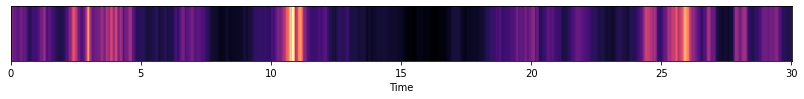

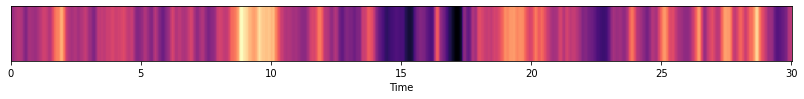

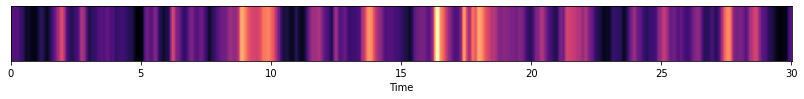

In [ ]:
import librosa.display
# Ваше решение
plt.figure(figsize=(14, 1))
librosa.display.specshow(rmse, sr=sr, x_axis='time')
plt.show()
plt.figure(figsize=(14, 1))
librosa.display.specshow(spec_cent, sr=sr, x_axis='time')
plt.show()
plt.figure(figsize=(14, 1))
librosa.display.specshow(spec_bw, sr=sr, x_axis='time')
plt.show()

In [ ]:
# Восстановление датасета аудио
# Данные привязаны к порядку следования меток классов!
# Порядок классов фиксирован сортировкой списка меток классов

with open('/content/audio_data_mean.pickle', 'rb') as f:
    x_train_data, y_train_data = pickle.load(f)

In [ ]:
# Нормирование признаков в соответствии со стандартным нормальным распределением

x_scaler = StandardScaler()
x_train_data_scaled = x_scaler.fit_transform(x_train_data)

In [ ]:
# Разделение набора данных на обучающую и проверочную выборки
# Параметр stratify указывает метки классов, по которым происходит балансировка разделения

x_train, x_val, y_train, y_val = train_test_split(x_train_data_scaled,
                                                  y_train_data,
                                                  stratify=y_train_data,
                                                  test_size=VALIDATION_SPLIT)